In [52]:
import scipy as sp
import os
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn import linear_model
import plotly.express as px
import plotly
import seaborn as sns


import japanize_matplotlib
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# 乱数seedの固定
np.random.seed(seed=123)

In [53]:
# E-step
def EStep(k_size, y, lambda_vec, coef_vec, sigma2_vec):
    '''
    y[i]
    lambda[k]
    mu[k]
    sigma[k]
    '''
    I = len(y)
    # 中身を初期化せずに配列を作成する関数である。
    # 2行, 1000列の配列を生成
    responsibility = sp.empty((k_size, I))
    
    """for k in sp.arange(k_size):
        norm = stats.norm(loc=np.mean(X@coef_vec[k]), scale=sp.sqrt(sigma2_vec[k]))
        responsibility[k] = lambda_vec[k] *norm.pdf(y)"""
    
    for k in sp.arange(k_size):
        _beta = X@coef_vec[k]
        _sigma = sigma2_vec[k]
        for i in range(I):
            responsibility[k][i] = np.exp((-(y[i] - _beta[i])**2) / (2*_sigma) )/ np.sqrt(2*np.pi*_sigma)

    responsibility = responsibility / sp.sum(responsibility, axis=0)
    return responsibility

def MStep(k_size, responsibility, y):

    lambda_vec = sp.empty(k_size)
    #mu_vec = sp.empty(k_size)
    coef_vec = []
    sigma2_vec = sp.empty(k_size)

    for k in sp.arange(k_size):
        r_k = responsibility[k]
        coef_vec.append(np.linalg.inv(X.T @ np.diag(r_k) @ X) @ X.T @np.diag(r_k)@y)
        lambda_vec[k] = sp.sum(r_k) / responsibility.shape[1]
        #mu_vec[k] = sp.sum(r_k * y) / sp.sum(r_k)
        sigma2_vec[k] = sp.sum(r_k * (y - np.mean(X@coef_vec[k]))**2) / sp.sum(r_k)
        
    mu_vec = [np.mean(X@coef_vec[0]), np.mean(X@coef_vec[1])]
        
    return lambda_vec, mu_vec, coef_vec, sigma2_vec

In [54]:
def calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec):
    pdf = sp.zeros_like(x)

    for k in sp.arange(k_size):
        norm_k = stats.norm(loc=np.mean(X@coef_vec[k]), scale=sp.sqrt(sigma2_vec[k]))
        
        # pdf (Probability density function) 確率密度関数
        # xのときの値を取得
        pdf += lambda_vec[k] * norm_k.pdf(x)
    return pdf

In [55]:
def calc_log_likelihood(X, coef_vec, sigma2_vec, lambda_vec, y):
    """
    norm1 = stats.norm(loc=X@coef_vec[0], scale=np.sqrt(sigma2_vec[0])).pdf(y)
    norm2 = stats.norm(loc=X@coef_vec[1], scale=np.sqrt(sigma2_vec[1])).pdf(y)
    likelihood=lambda_vec[0]*norm1 + lambda_vec[1]*norm2
    log_likelihood = np.sum(np.log(likelihood))
    """
    
    norm1 = np.exp((-(y -X@coef_vec[0])**2) / (2*sigma2_vec[0]) )/ np.sqrt(2*np.pi*sigma2_vec[0])
    norm2 = np.exp((-(y -X@coef_vec[1])**2) / (2*sigma2_vec[1]) )/ np.sqrt(2*np.pi*sigma2_vec[1])
    log_likelihood = responsibility[0]@np.log(norm1) + responsibility[1]@np.log(norm2) + np.sum(responsibility[0]*np.log( lambda_vec[0])+ responsibility[1]*np.log( lambda_vec[1]))

    return log_likelihood

# Config

In [160]:
# 　使用する変数
#FEATS = ["hf", "pop",  "urb", "gdp","dist", "air", "detection"]
#FEATS = ['urb', 'gdp', 'air', 'detection', 'HDI', 'median_age', 'dist_italy']
FEATS =["pop",  "gdp","dist", "air", "detection", "median_age", "population_density"]
exp_name = "exp10"
memo="hf・urb除く, 人口密度, 年齢中央値の追加"


NEW_DIR_PATH = f'output/{exp_name}/'
os.mkdir(NEW_DIR_PATH)

# データの作成

In [161]:
#df = pd.read_excel("../../data/data_covid_fix_name.xlsx")
#df = pd.read_csv("../../data/data_covid_fix_name_code_coordinate_ltaly.csv").iloc[:,1:]
df = pd.read_csv("../../data/data_covid_fix_name_code_coordinate_ltaly_medianage_hdi_density.csv")
df = df.dropna().reset_index(drop=True)

In [162]:
df.head(2)

,country,pop,urb,gdp,dist,hf,pf,ef,date_first,detection,...,cumul,air,code3,code2,lat,lon,dist_italy,median_age,HDI,population_density
0,Albania,2866376,60.319,13364.155397,6.996524e+06,7.84,8.005411,7.67,70,74.3,...,108641,303.14,ALB,AL,41.327546,19.818698,613446.033335,36.200001,0.792,104.612263
1,Algeria,42228429,72.629,15481.787620,9.108277e+06,4.99,5.201489,4.77,58,12.0,...,80272,6442.44,DZA,DZ,36.753768,3.058756,993497.660060,27.500000,0.746,17.730075


In [163]:
y=df["date_first"].values
#plt.hist(y, density=True)

### スケーリング(標準化)

In [164]:
df["dist_gdp"] = df["dist"] * df["gdp"]
df["dist_air"] = df["dist"] * df["air"]

df["log_pop"] = np.log(df["pop"])
df["log_air"] = np.log(df["air"])

tmp = df[[ "date_first"]+FEATS]
tmp.index = df["country"]
tmp

,date_first,pop,gdp,dist,air,detection,median_age,population_density
country,,,,,,,,
Albania,70,2866376,13364.155397,6.996524e+06,303.14,74.3,36.200001,104.612263
Algeria,58,42228429,15481.787620,9.108277e+06,6442.44,12.0,27.500000,17.730075
Angola,83,30809762,6452.355165,1.049012e+07,76.94,17.9,16.400000,24.713052
Argentina,65,44494502,20610.568550,1.902562e+07,1516.63,74.9,30.799999,16.258510
Australia,26,24992369,51663.365095,7.608913e+06,75667.65,97.3,37.400002,3.247871
...,...,...,...,...,...,...,...,...
Venezuela,76,28870195,18102.500000,1.505807e+07,2137.77,8.7,27.400000,32.730792
Vietnam,25,95540395,7447.814334,2.220676e+06,47049.67,57.4,30.400000,308.125246
Yemen,102,28498687,2575.126385,5.972543e+06,336.31,9.0,19.200001,53.977853


In [165]:
X = df[FEATS]
#X["population_density"] = np.log(X["population_density"])
#X["population_density"] = np.log(X["population_density"])
sscaler = preprocessing.StandardScaler() # インスタンスの作成
sscaler.fit(X)    
X = sscaler.transform(X) # xを変換
pd.DataFrame(X, columns=FEATS)

,pop,gdp,dist,air,detection,median_age,population_density
0,-0.311439,-0.433684,-0.366392,-0.299479,1.168601,0.713791,-0.147567
1,0.017707,-0.343016,0.163625,-0.222283,-1.629438,-0.261875,-0.273901
2,-0.077776,-0.729617,0.510445,-0.302324,-1.364456,-1.506690,-0.263747
3,0.036656,-0.123424,2.652719,-0.284221,1.195549,0.108205,-0.276041
4,-0.126421,1.206121,-0.212692,0.648163,2.201585,0.848366,-0.294959
...,...,...,...,...,...,...,...
143,-0.093995,-0.230809,1.656926,-0.276411,-1.777649,-0.273089,-0.252089
144,0.463501,-0.686996,-1.565053,0.288317,0.409582,0.063347,0.148358
145,-0.097101,-0.895623,-0.623394,-0.299062,-1.764175,-1.192682,-0.221194
146,-0.190312,-0.825030,0.308507,-0.303179,-1.184806,-1.428188,-0.265741


In [166]:
# データを早期、晩期に分割
y_early = df["date_first"][df["date_first"]<40]
y_late = df["date_first"][df["date_first"]>40]

x_early = X[df["date_first"]<40]
x_late = X[df["date_first"]>40]

# 初期値の設定  
- Rで計算済み

In [167]:
clf_early = linear_model.LinearRegression()
clf_early.fit(x_early, y_early)
# 決定係数
print("早期感染国の決定係数：", clf_early.score(x_early, y_early))

clf_late = linear_model.LinearRegression()
clf_late.fit(x_late, y_late)
 
# 決定係数
print("晩期感染国の決定係数：", clf_late.score(x_late, y_late))

早期感染国の決定係数： 0.6312536984065809
晩期感染国の決定係数： 0.47854346019965277


In [168]:
# 早期感染国のβ
coef1_first=[clf_early.intercept_] + list(clf_early.coef_)
#coef1_first=[1 for i in range(len(FEATS)+1)]

# 晩期感染国のβ
coef2_first=[clf_late.intercept_] + list(clf_late.coef_)
#coef2_first=[1 for i in range(len(FEATS)+1)]

first_df = pd.DataFrame(coef1_first, columns=["早期感染国β(初期値)"], index=["Intercept"]+ FEATS)
first_df["晩期感染国β(初期値)"] = coef2_first
first_df

,早期感染国β(初期値),晩期感染国β(初期値)
Intercept,38.153525,68.407410
pop,0.599467,-9.410139
gdp,0.096132,-3.146314
dist,8.400291,-0.039164
air,-1.551649,4.258383
detection,-1.450846,-2.337235
median_age,-2.475043,-3.797596
population_density,0.081952,-0.719148


### sigmaの初期値設定方法は要検討

In [169]:
# 切片の追加
X = np.insert(X, 0, 1, axis=1)

# muの初期値の計算
# mu = βx
mu1_first = np.mean(X@coef1_first)
mu2_first = np.mean(X@coef2_first)

# sigmaの初期値
sigma1_first = np.sum((y_early - np.mean(y_early))**2)/len(y_early)
sigma2_first = np.sum((y_late - np.mean(y_late))**2)/len(y_late)

In [170]:
# 混合正規分布の数
k_size = 2

# 混合比率
lambda_vec=[0.15, 0.85]

# 説明変数のパラメータ
mu_vec = [mu1_first, mu2_first]

# 分散(sigma)の初期値
sigma2_vec=[sigma1_first, sigma2_first]

# coefの初期値
coef_vec = [coef1_first, coef2_first]

In [171]:
print("f1の混合比率：", lambda_vec[0])
print("mu1：", mu_vec[0])
print("sigma1：", sigma2_vec[0])
print("")
print("f2の混合比率：", lambda_vec[1])
print("mu2：", mu_vec[1])
print("sigma2：", sigma2_vec[1])

f1の混合比率： 0.15
mu1： 38.15352483362428
sigma1： 27.16824196597353

f2の混合比率： 0.85
mu2： 68.4074098514356
sigma2： 100.12889600000001


### 初期値から生成される分布の確認

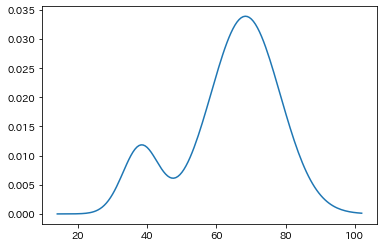

In [172]:
# データ(-6から6までを200こ)
x = sp.linspace(np.min(y), np.max(y), 150)
plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec), label="ini")

plt.savefig(NEW_DIR_PATH +"初期値plot.png")

# EMアルゴリズム

-592.5182548673855
i: 0 lambda [0.1796 0.8204] mu [41.8254 68.4801] sigma2 [263.8754 104.8444]
-640.4844654627417
i: 1 lambda [0.3174 0.6826] mu [52.7795 68.9191] sigma2 [474.3624 116.2501]
-662.5159169297309
i: 2 lambda [0.4059 0.5941] mu [57.7637 68.4159] sigma2 [505.304  123.7331]
-668.1728248100624
i: 3 lambda [0.4235 0.5765] mu [58.9446 67.8883] sigma2 [506.8493 129.7663]
-672.3414912918731
i: 4 lambda [0.4244 0.5756] mu [59.2799 67.4962] sigma2 [498.6294 146.3062]
-677.0979688767931
i: 5 lambda [0.4274 0.5726] mu [59.5108 67.2436] sigma2 [483.409  165.7775]
-681.1145107446189
i: 6 lambda [0.434 0.566] mu [59.7521 67.0639] sigma2 [468.974 180.779]
-684.1981719180033
i: 7 lambda [0.4389 0.5611] mu [59.9473 66.9737] sigma2 [456.2083 194.7547]
-686.6550153930173
i: 8 lambda [0.4427 0.5573] mu [60.0861 66.8444] sigma2 [443.7214 209.1637]
-688.4149977399934
i: 9 lambda [0.4482 0.5518] mu [60.1237 66.6811] sigma2 [432.5777 220.293 ]
-689.0503205789915
i: 10 lambda [0.4535 0.5465] mu [59

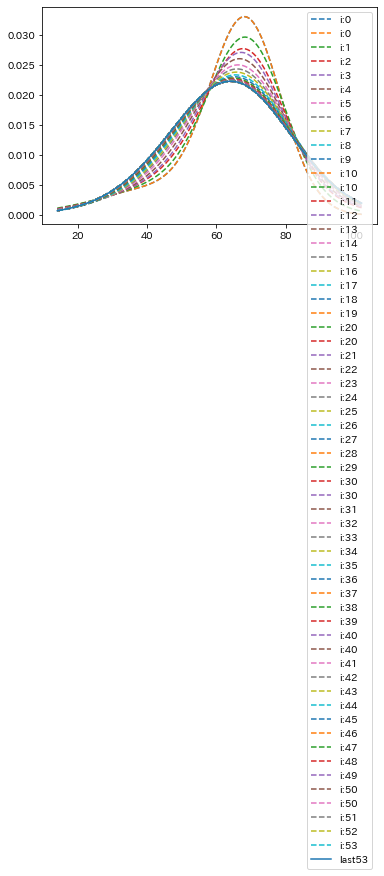

In [173]:
# 100回繰り返す
DIFF=0.000001
old=0
for i in sp.arange(100+1):
    # Estep # responsibilityの更新 
    responsibility = EStep(k_size, y, lambda_vec, coef_vec, sigma2_vec)
    
    # Mstep # 混合割合, 平均, 分散の更新
    lambda_vec, mu_vec, coef_vec, sigma2_vec = MStep(k_size, responsibility, y)
    plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec), label=f"i:{i}", linestyle="--")
    
    log_likelihood = calc_log_likelihood(X, coef_vec, sigma2_vec, lambda_vec, y)
    print(log_likelihood)
    print("i:", i, "lambda", lambda_vec.round(4), "mu", np.round(mu_vec, 4), "sigma2", sigma2_vec.round(4))
    
    if i !=0:
        diff = abs(log_likelihood - old)
        if diff <DIFF:
            break
    old = log_likelihood

    if i % 10 == 0:
        #print("i:", i, "lambda", lambda_vec.round(4), "mu", np.round(mu_vec, 4), "sigma2", sigma2_vec.round(4))
        plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec), label=f"i:{i}", linestyle="--")
        
plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec), label=f"last{i}", linestyle="-")

plt.legend()
plt.tight_layout()
plt.savefig(NEW_DIR_PATH +"EMplot.png")
plt.show()

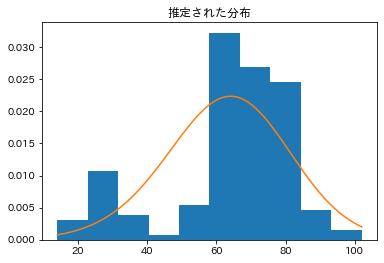

In [174]:
plt.hist(y, density=True)
plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec), label="ini")
plt.title("推定された分布")
plt.savefig(NEW_DIR_PATH +"実測値と推定された分布.png")

#### 注  
- mu1, mu2は反転する可能性があるため、f1, f2の混合比率を確認

In [175]:
print("f1の混合比率：", lambda_vec[0])
print("mu1：", mu_vec[0])
print("sigma1", sigma2_vec[0])

print("f2の混合比率：", lambda_vec[1])
print("mu2：", mu_vec[1])
print("sigma2：", sigma2_vec[1])

f1の混合比率： 0.4664949639217738
mu1： 59.587558498868
sigma1 403.7051793362783
f2の混合比率： 0.5335050360782262
mu2： 66.0357475541493
sigma2： 251.4444179128618


###  推定された分布の可視化

Text(0.5, 1.0, '推定された分布の可視化')

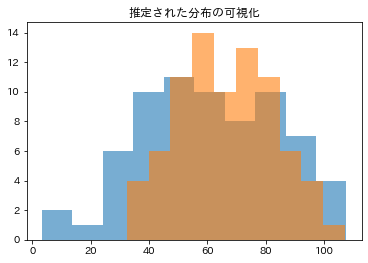

In [176]:
"""# 推定された分布の可視化
new_N1 = stats.norm(loc=mu_vec[0], scale=sp.sqrt(sigma2_vec[0]))
new_N2 = stats.norm(loc=mu_vec[1], scale=sp.sqrt(sigma2_vec[1]))

# rvs (Random variates) 確率変数
new_s1 = new_N1.rvs(size=int(lambda_vec[0]*150))
new_s2 = new_N2.rvs(size=int(lambda_vec[1]*150))


#plt.hist(y, bins=30, density=True)

plt.hist(new_s1, density=True, alpha=0.6)
plt.hist(new_s2, density=True, alpha=0.6)

"""
np.random.seed(seed=123)
new_s1 = np.random.normal(loc=mu_vec[0], scale=sp.sqrt(sigma2_vec[0]), size=int(lambda_vec[0]*150))
new_s2 = np.random.normal(loc=mu_vec[1], scale=sp.sqrt(sigma2_vec[1]), size=int(lambda_vec[1]*150))
plt.hist(new_s1, density=False, alpha=0.6)
plt.hist(new_s2, density=False, alpha=0.6)
plt.title("推定された分布の可視化")

Text(0.5, 1.0, '推定された分布の可視化')

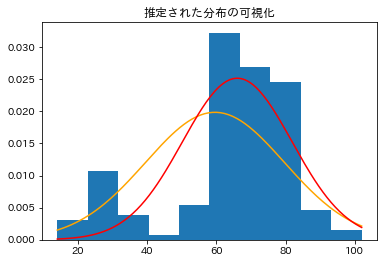

In [177]:
new_N1 = stats.norm.pdf(x, loc=mu_vec[0], scale=sp.sqrt(sigma2_vec[0]))
new_N2 = stats.norm.pdf(x, loc=mu_vec[1], scale=sp.sqrt(sigma2_vec[1]))

plt.hist(y, density=True,)
plt.plot(x, new_N1, color="orange")
plt.plot(x, new_N2, color="red")

plt.title("推定された分布の可視化")
#plt.savefig(NEW_DIR_PATH +"分布1と2の可視化.png")

#### 推定されたパラメータ

In [178]:
res_df = pd.DataFrame(coef_vec[0].round(4), index=["Intercept"]+FEATS,  columns=["分布1"])
res_df["分布2"] = coef_vec[1].round(4)
res_df

,分布1,分布2
Intercept,59.5876,66.0357
pop,1.7051,-3.4541
gdp,0.5155,-2.3715
dist,6.3649,0.6951
air,-23.6042,-1.9027
detection,-3.0591,-4.5845
median_age,-2.9018,-4.5892
population_density,-1.5010,-2.1523


# AIC

In [179]:
"""norm1 = 1/(2*np.pi*sigma2_vec[0])**(1/2) * np.exp((-1/2) *((y - X@coef_vec[0]) **2/sigma2_vec[0]) )
norm2 = 1/(2*np.pi*sigma2_vec[1])**(1/2) * np.exp((-1/2) *((y - X@coef_vec[1]) **2/sigma2_vec[1]) )

likelihood = responsibility[0]@np.log(norm1) + responsibility[1]@np.log(norm2) + np.sum(responsibility[0]*np.log( lambda_vec[0])) + np.sum(responsibility[1]*np.log( lambda_vec[1]))
print("対数尤度", likelihood)"""

"""norm1 = stats.norm(loc=X@coef_vec[0], scale=np.sqrt(sigma2_vec[0])).pdf(y)
norm2 = stats.norm(loc=X@coef_vec[1], scale=np.sqrt(sigma2_vec[1])).pdf(y)
likelihood=lambda_vec[0]*norm1 + lambda_vec[1]*norm2
log_likelihood = np.sum(np.log(likelihood))
print("対数尤度", log_likelihood)"""

norm1 = 1/(2*np.pi*sigma2_vec[0])**(1/2) * np.exp((-1/2) *((y - X@coef_vec[0]) **2/sigma2_vec[0]) )
norm2 = 1/(2*np.pi*sigma2_vec[1])**(1/2) * np.exp((-1/2) *((y - X@coef_vec[1]) **2/sigma2_vec[1]) )
log_likelihood = responsibility[0]@np.log(norm1) + responsibility[1]@np.log(norm2) + np.sum(responsibility[0]*np.log( lambda_vec[0])+ responsibility[1]*np.log( lambda_vec[1]))
print("対数尤度", log_likelihood)


対数尤度 -691.620671442678


In [180]:
k=len(coef_vec[0])+2 + len(coef_vec[1])+2
aic = -2*(log_likelihood)+ 2 *(k)
print("AIC", aic)

AIC 1423.241342885356


# 決定係数

In [181]:
#y_hat = np.diag(responsibility[0])@X@coef_vec[0]*lambda_vec[0] + np.diag(responsibility[1])@X@coef_vec[1]*lambda_vec[1]
#y_hat = (X@coef_vec[0])*lambda_vec[0] + (X@coef_vec[1])*lambda_vec[1]
y_hat = np.diag(responsibility[0])@(X@coef_vec[0]) + np.diag(responsibility[1])@(X@coef_vec[1])

In [182]:
from sklearn.metrics import r2_score
r2=r2_score( y, y_hat)
print("決定係数", r2)

決定係数 0.6846089519381907


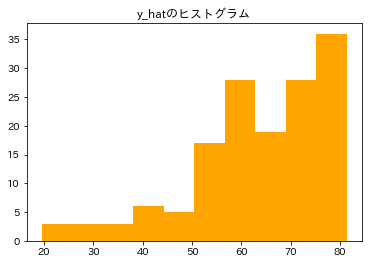

In [183]:
df["y_hat"] = y_hat


plt.hist(df["y_hat"], color="orange")
plt.title("y_hatのヒストグラム")
plt.savefig(NEW_DIR_PATH +"y_hatのヒストグラム.png")

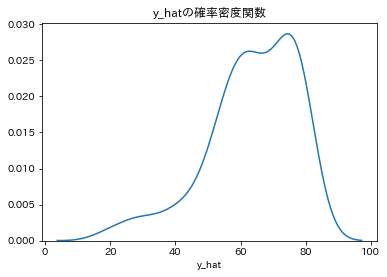

In [184]:
sns.distplot(df["y_hat"], bins=10,hist=False)
plt.title("y_hatの確率密度関数")
plt.savefig(NEW_DIR_PATH +"y_hatの確率密度関数.png")

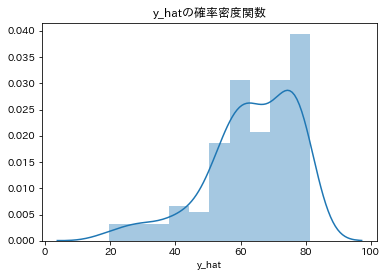

In [185]:
sns.distplot(df["y_hat"], bins=10,hist=True)
plt.title("y_hatの確率密度関数")
plt.savefig(NEW_DIR_PATH +"y_hatの確率密度関数(histあり).png")

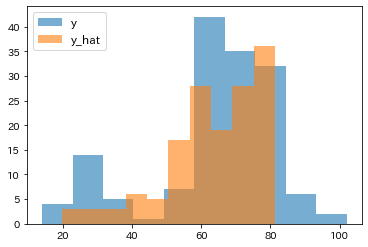

In [186]:
plt.hist(y,  alpha=0.6, label="y")
plt.hist(df["y_hat"],  alpha=0.6, label="y_hat")
#plt.title("y_hatのヒストグラム")
plt.legend(loc="upper left", fontsize=12)
plt.savefig(NEW_DIR_PATH +"yとy_hatのヒストグラム.png")

In [187]:
df["y_hat"].describe()

count    148.000000
mean      63.493243
std       13.875729
min       19.623765
25%       56.798713
50%       64.521373
75%       75.117797
max       81.304797
Name: y_hat, dtype: float64

# その他評価指標

In [188]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y, y_hat))
rmse

10.198256995231286

In [189]:
mse = mean_squared_error(y, y_hat)
mse

104.00444574078385

In [190]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y, y_hat)
mae

7.960069012402878

# 残差の可視化

In [191]:
df["y-y_hat"] = df["date_first"] - df["y_hat"]
df[["country", "date_first", "y_hat", "y-y_hat"]].head()

,country,date_first,y_hat,y-y_hat
0,Albania,70,59.250354,10.749646
1,Algeria,58,73.987955,-15.987955
2,Angola,83,80.834601,2.165399
3,Argentina,65,69.420844,-4.420844
4,Australia,26,39.288479,-13.288479


In [192]:
df[['country', 'pop', 'urb', 'gdp', 'dist', 'hf', 'date_first','detection', 'air',  'date_first', 'y_hat', "y-y_hat"]].sort_values("y-y_hat").head(10)

,country,pop,urb,gdp,dist,hf,date_first,detection,air,date_first,y_hat,y-y_hat
94,Nepal,28087871,19.740,3089.556352,2.081805e+06,6.51,26,22.0,3296.95,26,61.280905,-35.280905
126,Sri Lanka,21670000,18.476,13473.663094,3.971847e+06,6.41,29,43.0,5882.38,29,58.580838,-29.580838
23,Cambodia,16249798,23.388,4360.854404,2.643780e+06,7.13,29,57.7,1411.06,29,58.540177,-29.540177
46,Finland,5518050,85.382,48416.936030,5.823421e+06,8.53,31,61.6,13364.84,31,54.130161,-23.130161
41,Egypt,98423595,42.704,12412.309401,6.944423e+06,4.50,47,41.5,12340.83,47,66.353194,-19.353194
11,Belgium,11422068,98.001,51407.998337,7.548354e+06,8.29,36,62.5,13639.49,36,55.076702,-19.076702
144,Vietnam,95540395,35.919,7447.814334,2.220676e+06,6.29,25,57.4,47049.67,25,43.747482,-18.747482
129,Sweden,10183175,87.431,53208.884360,6.323651e+06,8.50,33,86.0,11623.92,33,51.316466,-18.316466
108,Philippines,106651922,46.907,8951.085654,3.345565e+06,6.88,31,63.6,43080.12,31,48.832054,-17.832054
47,France,66987244,80.444,45342.395736,8.550121e+06,8.02,26,75.3,70188.03,26,43.253816,-17.253816


In [193]:
tmp = df[['country', 'date_first', 'y_hat', "y-y_hat"]].sort_values("y-y_hat").head(10)
tmp.columns=['country', '実測値', '推定値', "残差"]
tmp

,country,実測値,推定値,残差
94,Nepal,26,61.280905,-35.280905
126,Sri Lanka,29,58.580838,-29.580838
23,Cambodia,29,58.540177,-29.540177
46,Finland,31,54.130161,-23.130161
41,Egypt,47,66.353194,-19.353194
11,Belgium,36,55.076702,-19.076702
144,Vietnam,25,43.747482,-18.747482
129,Sweden,33,51.316466,-18.316466
108,Philippines,31,48.832054,-17.832054
47,France,26,43.253816,-17.253816


In [194]:
df[['country', 'pop', 'urb', 'gdp', 'dist', 'hf', 'date_first','detection', 'air',  'date_first', 'y_hat', "y-y_hat"]].sort_values("y-y_hat", ascending=False).head(10)



,country,pop,urb,gdp,dist,hf,date_first,detection,air,date_first,y_hat,y-y_hat
145,Yemen,28498687,36.642,2575.126385,5.972543e+06,4.30,102,9.0,336.31,102,78.788358,23.211642
17,Botswana,2254126,69.446,18615.793336,1.061168e+07,7.17,93,28.2,253.42,93,75.327390,17.672610
90,Montenegro,622345,66.813,20689.986751,6.977422e+06,7.43,79,55.4,565.52,79,61.659989,17.340011
86,Mauritius,1265303,40.793,23750.988040,7.927009e+06,7.52,81,42.3,1745.29,81,63.744994,17.255006
119,Sierra Leone,7650154,42.055,1601.974029,1.166188e+07,5.99,93,45.8,50.19,93,76.214140,16.785860
82,Malawi,18143315,16.937,1310.995555,9.123415e+06,6.60,95,23.3,10.54,95,78.482623,16.517377
74,Kyrgyzstan,6315800,36.351,3884.708809,2.580872e+06,6.98,80,64.7,709.20,80,63.917889,16.082111
93,Myanmar,53708395,30.579,6674.028647,1.848397e+06,5.44,78,59.2,3407.79,78,61.955321,16.044679
78,Libya,6678567,80.102,20764.164136,7.927990e+06,4.64,86,36.0,927.15,86,70.437319,15.562681
65,Ireland,4853506,63.170,83203.394677,8.108624e+06,8.52,62,78.0,167598.63,62,46.502615,15.497385


In [195]:
tmp = df[['country', 'date_first', 'y_hat', "y-y_hat"]].sort_values("y-y_hat", ascending=False).head(10)
tmp.columns=['country', '実測値', '推定値', "残差"]
tmp


,country,実測値,推定値,残差
145,Yemen,102,78.788358,23.211642
17,Botswana,93,75.327390,17.672610
90,Montenegro,79,61.659989,17.340011
86,Mauritius,81,63.744994,17.255006
119,Sierra Leone,93,76.214140,16.785860
82,Malawi,95,78.482623,16.517377
74,Kyrgyzstan,80,63.917889,16.082111
93,Myanmar,78,61.955321,16.044679
78,Libya,86,70.437319,15.562681
65,Ireland,62,46.502615,15.497385


In [196]:
# 実測値の可視化
fig =px.choropleth(
    df,
    locations="code3",
    color="date_first",
    hover_name="country",
    range_color=[0,102],
    #animation_frame='variable',
    #projection="natural earth",
    color_continuous_scale=list(reversed(px.colors.sequential.OrRd)),
                                )

fig.show()
#plotly.offline.plot(fig, filename='output/実測値の可視化.png')

In [197]:
# 予測値の可視化
fig = px.choropleth(
    df,
    locations="code3",
    color="y_hat",
    hover_name="country",
    #range_color=[0,102],
    #animation_frame='variable',
    #projection="natural earth",
    color_continuous_scale=list(reversed(px.colors.sequential.OrRd)),
                                )
fig.show()
plotly.offline.plot(fig, filename=NEW_DIR_PATH + "y_hatの可視化.html")

'output/exp10/y_hatの可視化.html'

In [198]:
# 残差の可視化
fig = px.choropleth(
    df,
    locations="code3",
    color="y-y_hat",
    hover_name="country",
    #range_color=[0,102],
    #animation_frame='variable',
    #projection="natural earth",
    color_continuous_scale=list(reversed(px.colors.sequential.RdBu)),
                                )
fig.show()
plotly.offline.plot(fig, filename=NEW_DIR_PATH + "残差の可視化.html")

'output/exp10/残差の可視化.html'

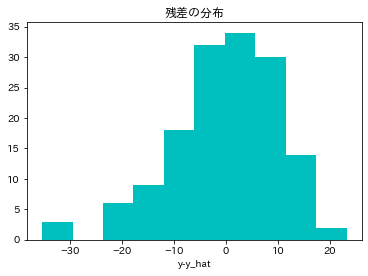

In [199]:
plt.hist(df["y-y_hat"], color="c")
plt.title("残差の分布")
plt.xlabel("y-y_hat")
plt.savefig(NEW_DIR_PATH +"残差の分布.png")

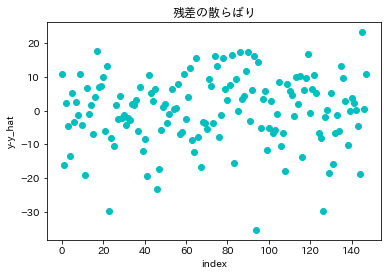

In [200]:
plt.scatter(df.index, df["y-y_hat"], color="c")
plt.title("残差の散らばり")
plt.xlabel("index")
plt.ylabel("y-y_hat")
plt.savefig(NEW_DIR_PATH +"残差の散らばり.png")

In [201]:
# gammaの可視化
df["z"] = responsibility[0].round(2)
fig = px.choropleth(
    df,
    locations="code3",
    color="z",
    hover_name="country",
    #range_color=[0,102],
    #animation_frame='variable',
    #projection="natural earth",
    color_continuous_scale=list(px.colors.sequential.OrRd),
                                )
fig.show()
plotly.offline.plot(fig, filename=NEW_DIR_PATH + "zの可視化.html")

'output/exp10/zの可視化.html'

In [202]:
write_df = pd.DataFrame({
    "実験名":exp_name,
    "memo":memo,
    "説明変数":[FEATS],
    "分布1のβ":[coef_vec[0].round(4)],
    "分布2のβ":[coef_vec[1].round(4)],
    "混合比率":[lambda_vec.round(4)],
    "平均":[np.round(mu_vec, 4)],
    "分散":[np.round(sigma2_vec, 4)],
    "対数尤度":log_likelihood.round(4),
    "パラメータ数":k,
    "AIC":aic.round(4),
    "決定係数":r2.round(4),
    "RMSE":rmse.round(4),
    "MAE":mae.round(4)
})
write_df

,実験名,memo,説明変数,分布1のβ,分布2のβ,混合比率,平均,分散,対数尤度,パラメータ数,AIC,決定係数,RMSE,MAE
0,exp10,"hf・urb除く, 人口密度, 年齢中央値の追加","[pop, gdp, dist, air, detection, median_age, p...","[59.5876, 1.7051, 0.5155, 6.3649, -23.6042, -3...","[66.0357, -3.4541, -2.3715, 0.6951, -1.9027, -...","[0.4665, 0.5335]","[59.5876, 66.0357]","[403.7052, 251.4444]",-691.6207,20,1423.2413,0.6846,10.1983,7.9601


In [203]:
PATH="output/2成分混合回帰実験管理.xlsx"
excel_df = pd.read_excel(PATH)
excel_df = pd.concat([excel_df, write_df]).reset_index(drop=True)
excel_df.to_excel(PATH, sheet_name = "all", index=False)

write_df.to_excel(PATH, sheet_name = exp_name)

In [204]:
FILE_NAME = "2成分混合回帰モデル_変数選択.ipynb"
f"{NEW_DIR_PATH}{FILE_NAME}"

'output/exp10/2成分混合回帰モデル_変数選択.ipynb'

In [154]:
!cp "2成分混合回帰モデル_変数選択.ipynb" 'output/exp10/2成分混合回帰モデル_変数選択.ipynb'

# t値

In [155]:
sse =  np.sum((y - y_hat) **2, axis=0)
sse = sse / (X.shape[0] - X.shape[1] -1 )
X_tmp = X-X.mean()
ss_ij = np.linalg.inv(X_tmp.T@X_tmp)
std_err2 = np.sqrt(np.diagonal(sse * ss_ij))
std_err2

print("std_err : ", std_err2)

std_err :  [0.9859845  0.96083674 1.28726309 1.39794827 0.99576592 1.02084219
 1.05132507 1.3209455  0.90067652]


In [156]:
t_value1 = coef_vec[0]/std_err2
t_value2 = coef_vec[1]/std_err2

# p値

In [157]:
from scipy import stats
p_values1 =[2*(1-stats.t.cdf(np.abs(i),(len(X)-len(X[0])))) for i in t_value1]
pd.DataFrame(np.round(p_values1, 3))

,0
0,0.000
1,0.067
2,0.843
3,0.658
4,0.000
5,0.000
6,0.007
7,0.021
8,0.079


In [158]:
from scipy import stats
p_values2 =[2*(1-stats.t.cdf(np.abs(i),(len(X)-len(X[0])))) for i in t_value2]
pd.DataFrame(np.round(p_values2, 3))

,0
0,0.000
1,0.000
2,0.000
3,0.795
4,0.035
5,0.059
6,0.000
7,0.033
8,0.032


In [159]:
res_df = pd.DataFrame(coef_vec[0].round(4), index=["Intercept"]+FEATS,  columns=["分布1"])
res_df["分布1_p値"] =np.round(p_values1, 4)
res_df["分布2"] = coef_vec[1].round(4)
res_df["分布2_p値"] =np.round(p_values2, 4)
res_df

,分布1,分布1_p値,分布2,分布2_p値
Intercept,59.5942,0.0000,65.9322,0.0000
pop,1.7718,0.0673,-3.4690,0.0004
urb,0.2547,0.8434,-4.7526,0.0003
gdp,0.6196,0.6583,-0.3634,0.7953
dist,6.2862,0.0000,2.1259,0.0345
air,-23.7943,0.0000,-1.9428,0.0591
detection,-2.8987,0.0066,-4.8116,0.0000
median_age,-3.0948,0.0206,-2.8408,0.0332
population_density,-1.5961,0.0786,-1.9560,0.0316


In [61]:
import statsmodels.api as sm
  
model_early = sm.OLS(y_early, sm.add_constant(x_early))
result_early = model_early.fit()
result_early.summary(xname=["Interscept"]+FEATS) 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             date_first   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                     2.909
Date:                Wed, 20 Jan 2021   Prob (F-statistic):             0.0396
Time:                        17:14:59   Log-Likelihood:                -57.922
No. Observations:                  23   AIC:                             135.8
Df Residuals:                      13   BIC:                             147.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Interscept            37.6484      3.696     10.185      0.000      29.663      45.634
hf                     2.3752      2.148      1.106      0.289      -2.264       7.015
pop                    0.5572      0.435      1.280      0.223      -0.383       1.497
urb                    0.3863      2.247      0.172      0.866      -4.469       5.242
gdp                   -0.3532      3.027     -0.117      0.909      -6.893       6.186
dist                   7.5265      2.338      3.219      0.007       2.475      12.578
air                   -1.4499      0.540     -2.686      0.019      -2.616      -0.284
detection             -2.3927      1.604     -1.492      0.160      -5.858       1.073
median_age            -3.4013      1.899     -1.791      0.097      -7.504       0.701
population_density     0.0296      0.666      0.044      0.965      -1.410       1.469
==============================================================================
Omnibus:                        3.463   Durbin-Watson:                   2.525
Prob(Omnibus):                  0.177   Jarque-Bera (JB):                2.820
Skew:                          -0.758   Prob(JB):                        0.244
Kurtosis:                       2.197   Cond. No.                         19.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [62]:
import statsmodels.api as sm
  
model_late = sm.OLS(y_late, sm.add_constant(x_late))
result_late = model_late.fit()
result_late.summary(xname=["Interscept"]+FEATS) 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             date_first   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     15.23
Date:                Wed, 20 Jan 2021   Prob (F-statistic):           4.47e-16
Time:                        17:14:59   Log-Likelihood:                -416.22
No. Observations:                 125   AIC:                             852.4
Df Residuals:                     115   BIC:                             880.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Interscept            68.5709      0.746     91.894      0.000      67.093      70.049
hf                     0.5483      1.022      0.536      0.593      -1.476       2.572
pop                   -8.4117      2.242     -3.753      0.000     -12.852      -3.972
urb                   -3.6624      0.965     -3.797      0.000      -5.573      -1.752
gdp                   -1.3434      1.054     -1.275      0.205      -3.431       0.744
dist                   1.0107      0.802      1.260      0.210      -0.578       2.599
air                    4.3057      2.691      1.600      0.112      -1.025       9.636
detection             -2.6044      0.853     -3.053      0.003      -4.294      -0.915
median_age            -2.8683      1.168     -2.455      0.016      -5.183      -0.554
population_density    -0.3947      1.684     -0.234      0.815      -3.729       2.940
==============================================================================
Omnibus:                        5.793   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.055   Jarque-Bera (JB):                7.157
Skew:                           0.243   Prob(JB):                       0.0279
Kurtosis:                       4.067   Cond. No.                         8.43
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### ✅hf, pop, urb, gdp, air, detection, dist_itary

In [69]:
res_df

,分布1,分布2
Intercept,27.8169,68.9503
hf,2.1937,-0.9721
pop,0.3344,-9.8995
urb,-1.0413,-4.3070
gdp,0.4835,-1.9898
air,-0.6551,4.4905
detection,-1.0642,-2.5043
dist_italy,-2.3026,2.5252


In [111]:
k=len(coef_vec[0])+2 + len(coef_vec[1])+2
aic = -2*(log_likelihood)+ 2 *(k)
print("AIC", aic)

AIC 1169.1093682602955


/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.zeros_like is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros_like instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  after removing the cwd from sys.path.
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  """


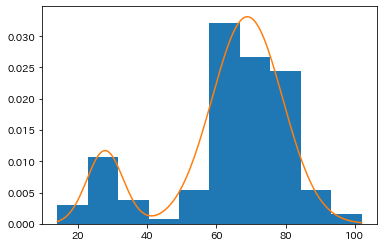

In [72]:
plt.hist(y, density=True)
plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec), label="ini")

### ✅hf, pop, urb, gdp, air, dist

In [159]:
res_df

,早期感染国,晩期感染国
Intercept,60.2320,68.3693
hf,-6.7426,-1.8981
pop,-1.7336,-7.4032
urb,-4.9434,-4.0617
gdp,-0.5626,-1.3212
air,-3.4071,2.0536
dist,13.1993,1.7964


In [160]:
first_df

,早期感染国β(初期値),晩期感染国β(初期値)
Intercept,34.144527,68.705715
hf,-0.574947,-2.193724
pop,0.704297,-9.775305
urb,-1.465996,-4.893013
gdp,0.742538,-1.552997
air,-1.592736,3.112941
dist,7.020140,2.045302


/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.zeros_like is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros_like instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  after removing the cwd from sys.path.
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  """


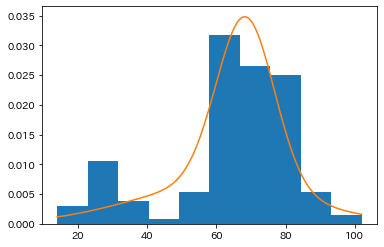

In [161]:
plt.hist(y, density=True)
plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec), label="ini")

### ✅hf, pop, urb, gdp, air, detection

In [200]:
res_df

,早期感染国,晩期感染国
Intercept,27.6720,68.8998
hf,3.7881,-0.6450
pop,0.3898,-9.3063
urb,-0.2511,-4.0103
gdp,-0.1208,-2.8115
air,-0.6565,4.9016
detection,-2.4609,-2.9686


In [201]:
first_df

,早期感染国β(初期値),晩期感染国β(初期値)
Intercept,27.706694,68.924369
hf,3.847780,-0.651066
pop,0.389038,-9.473606
urb,-0.212951,-3.997060
gdp,-0.160500,-2.824348
air,-0.655912,5.035802
detection,-2.507140,-2.943951


/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.zeros_like is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros_like instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  after removing the cwd from sys.path.
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  """


Text(0.5, 1.0, '推定された分布')

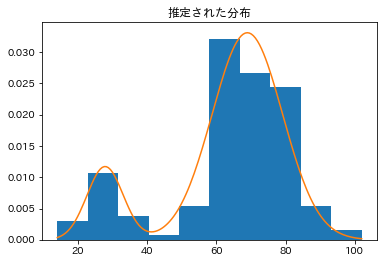

In [133]:
plt.hist(y, density=True)
plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec), label="ini")
plt.title("推定された分布")

### ✅hf, pop, urb, gdp, air

In [134]:
res_df

,早期感染国,晩期感染国
Intercept,25.9985,68.8723
hf,2.2768,-1.9647
pop,0.5155,-10.5575
urb,-1.3567,-4.0571
gdp,1.1242,-2.8229
air,-0.9666,3.5627


In [135]:
first_df

,早期感染国β(初期値),晩期感染国β(初期値)
Intercept,26.053547,68.907071
hf,2.282413,-1.960874
pop,0.516722,-10.823974
urb,-1.277986,-4.032543
gdp,1.067690,-2.843152
air,-0.975720,3.781667


/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.zeros_like is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros_like instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  after removing the cwd from sys.path.
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  """


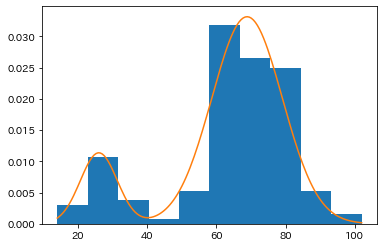

In [136]:
plt.hist(y, density=True)
plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec), label="ini")

# 改善事項  
- p値  
- 信頼区間  
- AIC  
  
  
- 対数化しない場合  
- 変数選択  
- f1とf2で変数を帰る

# 散布図行列

In [116]:
data = df.copy()
data = data[["date_first", "hf", "pop",  "urb", "gdp","dist", "air", "detection"]]
data["flag"]=0
data.loc[data["date_first"]>40, "flag"]=1

/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


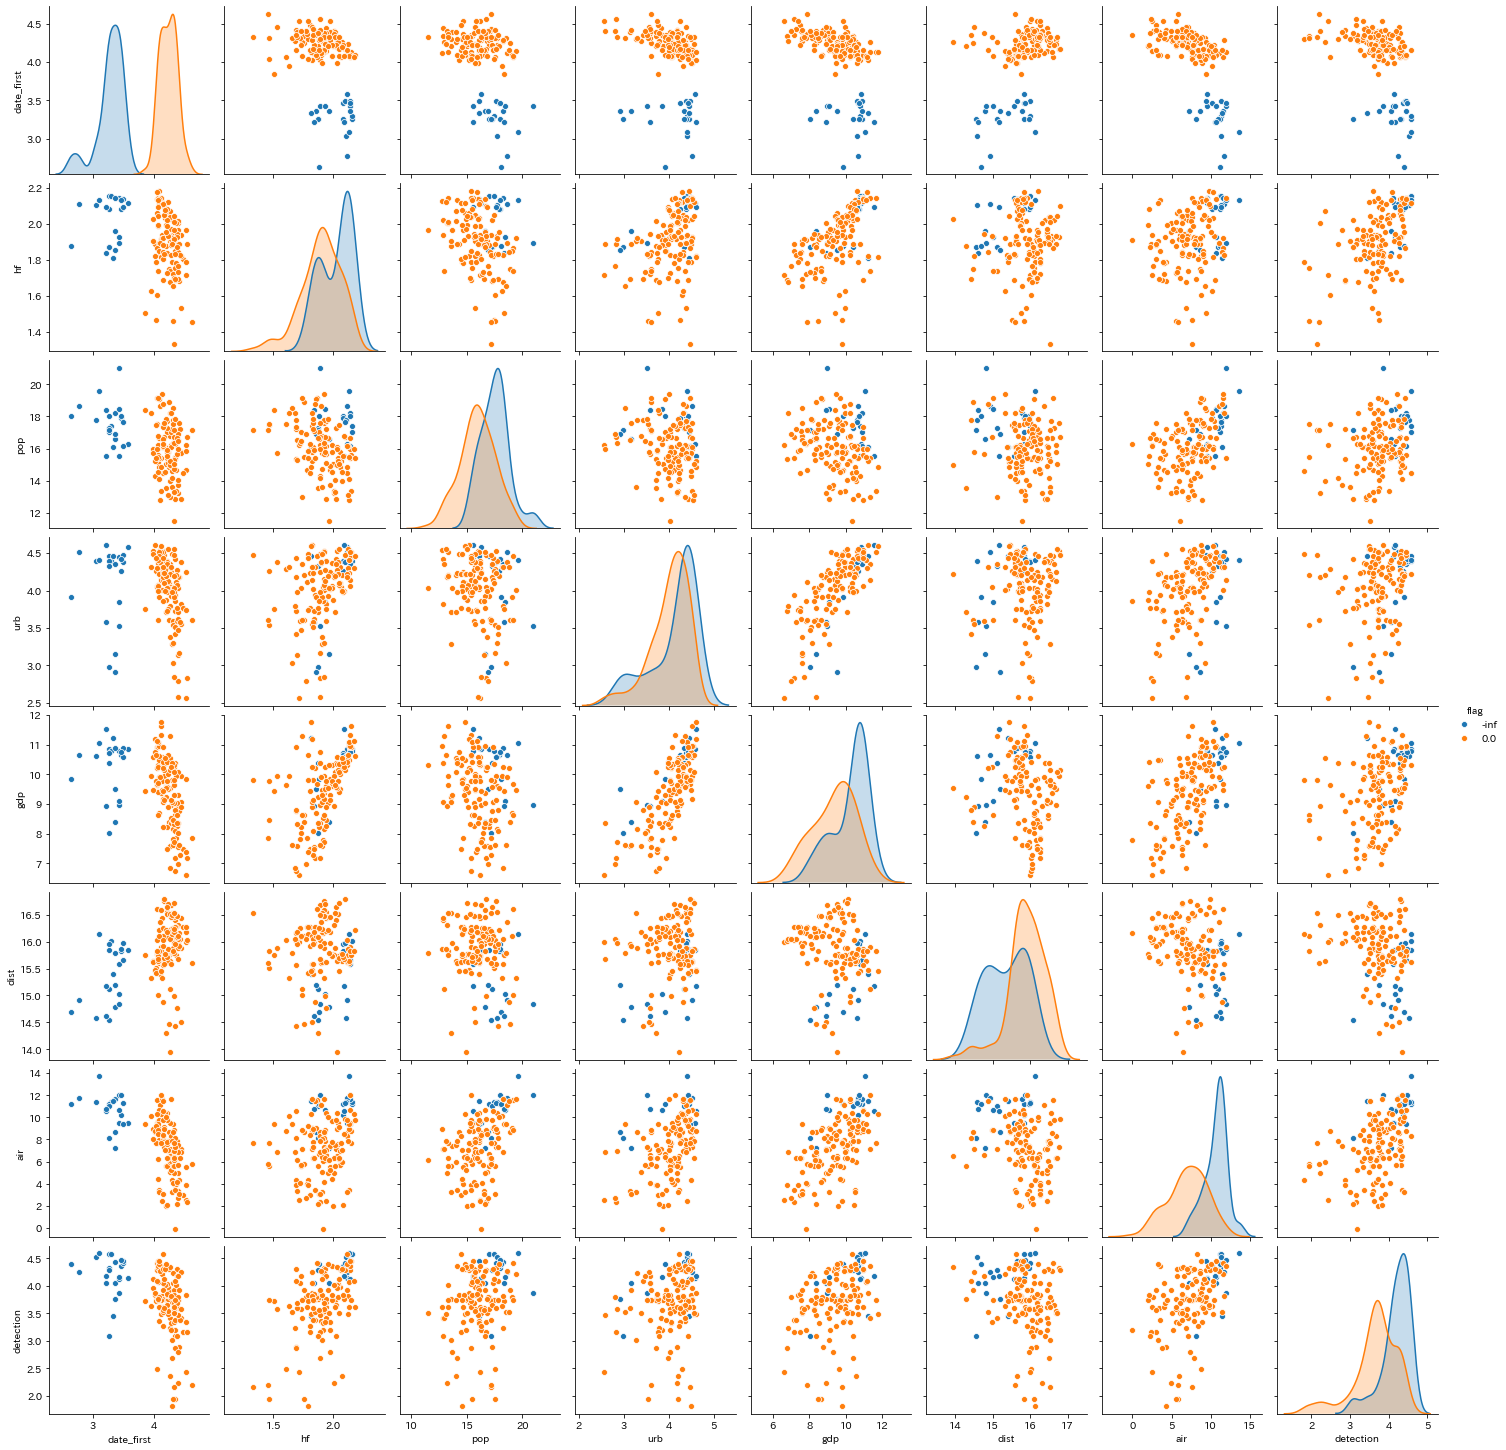

In [26]:
import seaborn as sns
sns.pairplot(np.log(data), hue='flag')